In [1]:
!pip install chess
!pip install stockfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 332.9 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148495 sha256=1f30867a8087c0517bfcb6328c122b485ccdb9d5c188227520b8cec24d9984d4
  Stored in directory: /home/jovyan/.cache/pip/wheels/f0/3f/76/8783033e8524d407e1bebaf72fdd3f3eba27e0c030e92bbd87
Successfully built chess


In [1]:
import os
import pickle
import shutil
import chess
import chess.engine
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
from stockfish import Stockfish
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
KAGGLE = False

if KAGGLE:
    input_stockfish_path = "/kaggle/input/stockfish_ubuntu/other/default/1/stockfish-ubuntu-x86-64-avx2"
    stockfish_path = "/kaggle/working/stockfish"
    if not os.path.exists(stockfish_path):
        shutil.copy(input_stockfish_path, stockfish_path)
    os.chmod(stockfish_path, 0o755)
else:
    stockfish_path = "./stockfish-ubuntu-x86-64-avx2"
    os.chmod(stockfish_path, 0o755)
    
stockfish = Stockfish(path=stockfish_path)
stockfish.set_skill_level(20)


In [7]:
class MaskLayer(nn.Module):
    def __init__(self):
        super(MaskLayer, self).__init__()
    
    def forward(self, x, mask):
        return torch.mul(x, mask)

class SpatialAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(SpatialAttentionLayer, self).__init__()
        self.conv1 = nn.Conv2d(channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.sigmoid(self.conv1(x))  # Generate attention map
        return x * attention  # Apply attention map

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # If dimensions mismatch, use a 1x1 convolution to match dimensions
        self.downsample = None
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Apply downsample if dimensions mismatch
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual  # Add skip connection
        return self.relu(out)

class ChessDQN(nn.Module):
    def __init__(self):
        super(ChessDQN, self).__init__()

        # Initial convolution layers
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Residual blocks
        self.res_block1 = ResidualBlock(32, 32)
        self.res_block2 = ResidualBlock(32, 64)
        
        # Second convolution layers
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Attention layer
        self.attention = SpatialAttentionLayer(128)
        
        # Third convolution layers
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 64, 256 * 64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256 * 64, 128 * 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128 * 64, 64 * 64)
        
        # Mask layer
        self.mask = MaskLayer()

    def forward(self, x, mask=None, debug=False):
        # Convolution + BatchNorm + ReLU
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        # Second convolution
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        
        # Attention mechanism
        x = self.attention(x)
        
        # Third convolution
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        
        # Flatten for fully connected layers
        x = nn.Flatten()(x)
        
        # Fully connected layers with Dropout
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # Output layer (no activation)
        
        # Masking output if provided
        if mask is not None:
            x = self.mask(x, mask)
            
        return x


In [8]:
class ChessAgent:
    def __init__(self, model_path=None):
        self.epsilon = 1.0
        self.epsilon_decay = 0.999999999
        self.epsilon_min = 0.01
        self.gamma = 0.3 # Balance between immediate and long-term rewards
        self.learning_rate = 1e-03
        self.MEMORY_SIZE = 256 # how many steps to store for experience replay
        self.MAX_PRIORITY = 1e+06 # max priority for a sample in memory. The higher the priority, the more likely the sample will be included in training
        self.memory = []
        self.batch_size = 30
        
        self.policy_net = ChessDQN().to(device)
        if model_path and os.path.exists(model_path):
            state_dict = torch.load(model_path, weights_only=True)
            self.policy_net.load_state_dict(state_dict)  

        for param in self.policy_net.parameters():
            param.requires_grad = True

        self.loss_function = nn.MSELoss()
        self.optimizer = Adam(self.policy_net.parameters(), lr=self.learning_rate)

        self.stockfish = Stockfish(path=stockfish_path)
        self.stockfish.set_skill_level(20)

    def convert_board_to_bitarray(self, board):
        """
        Convert the chess board state to a 3D bitarray.
        """
        piece_bitboards = {
            (chess.piece_symbol(pt).upper() if color else chess.piece_symbol(pt)): board.pieces_mask(pt, color)
            for pt in chess.PIECE_TYPES for color in chess.COLORS
        }
        piece_bitboards['-'] = board.occupied ^ (2**64 - 1)
        player = (2**64 - 1) if board.turn else 0
        castling_rights = board.castling_rights
        en_passant = 0
        if board.ep_square is not None:
            en_passant = 1 << board.ep_square

        bitboards = list(piece_bitboards.values()) + [player, castling_rights, en_passant]
        # convert each bitboard into a matrix 1 and 0
        bitarray = np.array([[((bb >> i) & 1) for i in range(64)] for bb in bitboards]).reshape((16, 8, 8))

        return bitarray
        
    def get_move_index(self, move):
        """
        Map a chess.Move object to a unique index.
        """
        return 64 * (move.from_square) + (move.to_square)

    def mask_valid_moves(self, board):
        """
        Create a tensor mask of valid moves and a dictionary of move indices.
        """
        mask = np.zeros((64, 64))
        move_dict  = {}
        for move in board.legal_moves:
            mask[move.from_square, move.to_square] = 1
            move_dict[self.get_move_index(move)] = move
        return torch.from_numpy(mask.flatten()), move_dict

    def select_action(self, board, evaluate=False):
        """
        Choose an action based on the current board state.
        Use an epsilon-greedy strategy.
        """
        bit_state = self.convert_board_to_bitarray(board)
        valid_moves_tensor, legal_moves = self.mask_valid_moves(board)
    
        if np.random.rand() < self.epsilon and not evaluate:
            if random.uniform(0, 1) <= 0.8:
                self.stockfish.set_fen_position(board.fen())
                chosen_move = chess.Move.from_uci(self.stockfish.get_best_move())
            else:
                chosen_move = random.choice(list(board.legal_moves))
        else:
            state_tensor = torch.tensor(bit_state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = self.policy_net(state_tensor)
            q_values = q_values.detach().cpu().numpy().flatten()
            valid_q_values = q_values * valid_moves_tensor.numpy()
            best_action_index = np.argmax(valid_q_values)
            chosen_move = legal_moves.get(best_action_index, random.choice(list(board.legal_moves)))
    
        return self.get_move_index(chosen_move), chosen_move, bit_state, valid_moves_tensor

    def remember(self, priority, state, action, reward, next_state, done, valid_moves, next_valid_moves):
        """
        Store a step in memory, ensuring it doesn't exceed maximum size.
        """
        if len(self.memory) >= self.MEMORY_SIZE:
            min_index = np.argmin([sample[0] for sample in self.memory])
            del self.memory[min_index]
        self.memory.append((priority, state, action, reward, next_state, done, valid_moves, next_valid_moves))
    
    def adaptive_epsilon_decay(self):
        """
        Reduce epsilon over time for less exploration.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def save_model(self, path):
        """
        Save the model weights to a file.
        """
        torch.save(self.policy_net.state_dict(), path)

    def experience_replay(self):
        """
        Perform experience replay to update the model's policy network using a prioritized replay buffer.
        """
        if len(self.memory) < self.batch_size:
            return
    
        priorities = np.array([sample[0] for sample in self.memory])
        # probabilities = priorities / np.sum(priorities)
        epsilon = 1e-6
        probabilities = (priorities + epsilon) / (np.sum(priorities) + epsilon * len(priorities))
    
        minibatch_indexes = np.random.choice(len(self.memory), size=self.batch_size, replace=False, p=probabilities)
        minibatch = [self.memory[x] for x in minibatch_indexes]
        
        states, state_valid_moves, actions, rewards, next_states, next_state_valid_moves, dones = [], [], [], [], [], [], []
    
        for priority, bit_state, action, reward, next_bit_state, done, state_valid_move, next_state_valid_move in minibatch:
            states.append(bit_state)
            state_valid_moves.append(state_valid_move.unsqueeze(0))
            actions.append([action])
            rewards.append(reward)
            dones.append(done)
    
            if not done:
                next_states.append(next_bit_state)
                next_state_valid_moves.append(next_state_valid_move.unsqueeze(0))

        # states = np.array(states)
        # actions = np.array(actions)
        # next_states = np.array(next_states)
        # rewards = np.array(rewards)
        state_tensor = torch.tensor(states, dtype=torch.float32, device=device)
        action_tensor = torch.tensor(actions, dtype=torch.int64, device=device)
        reward_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_state_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)
        not_done_mask = torch.tensor([not done for done in dones], dtype=torch.bool, device=device)
        state_valid_tensor = torch.cat(state_valid_moves).to(device)
        next_state_valid_tensor = torch.cat(next_state_valid_moves).to(device)

        policy_q_values = self.policy_net(state_tensor, state_valid_tensor).gather(1, action_tensor)
        with torch.no_grad():
            next_q_values = torch.zeros(self.batch_size, dtype=torch.double, device=device)
            next_q_values[not_done_mask] = self.policy_net(next_state_tensor, next_state_valid_tensor).max(1)[0]
    
        target_q_values = reward_tensor + self.gamma * next_q_values
        target_q_values = target_q_values.unsqueeze(1)

        loss = self.loss_function(policy_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        priority = F.mse_loss(policy_q_values, target_q_values, reduction='mean').detach().cpu().numpy()
        for idx, new_priority in zip(minibatch_indexes, priorities):
            self.memory[idx] = (new_priority, *self.memory[idx][1:])
    
        return float(loss)

    def generate_random_sample(self, board):
        """
        Generate a random sample for training by simulating a move.
        """
        priority = 1
        state = self.convert_board_to_bitarray(board)
        valid_moves, _ = self.mask_valid_moves(board)

        self.stockfish.set_fen_position(board.fen())
        random_move = chess.Move.from_uci(self.stockfish.get_best_move())
        action = self.get_move_index(random_move)
        self.stockfish.set_fen_position(board.fen())
        board_score_before = self.stockfish.get_evaluation()['value']
        board.push(random_move)

        self.stockfish.set_fen_position(board.fen())
        random_move_black = chess.Move.from_uci(self.stockfish.get_best_move())
        board.push(random_move_black)
        self.stockfish.set_fen_position(board.fen())
        board_score_after = self.stockfish.get_evaluation()['value']

        next_state = self.convert_board_to_bitarray(board)
        done = board.result() != '*'
        next_valid_moves, _ = self.mask_valid_moves(board)

        board.pop()
        board.pop()
        
        reward = board_score_after / 100 - board_score_before / 100 - 0.01
        
        self.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)

    def calculate_endgame_reward(self, result, board_score_before):
        """
        Calculate the reward based on the endgame result.
        """
        if result == "1-0":  # White wins
            reward = 1.0
        elif result == "0-1":  # Black wins
            reward = -1.0
        elif result == "1/2-1/2":  # Draw
            reward = 0.0
        else:  # Should not occur, but for safety
            reward = 0.0
    
        done = True
        return reward, done
    

    def generate_random_sample(self, board):
        """
        Generate a random sample for training by simulating a move.
        """
        priority = 1
        state = self.convert_board_to_bitarray(board)
        valid_moves, _ = self.mask_valid_moves(board)
    
        # Stockfish move for white
        self.stockfish.set_fen_position(board.fen())
        best_move_white = self.stockfish.get_best_move()
        if best_move_white is None or board.is_game_over():
            print("Game over or no move for white.")
            return
    
        random_move_white = chess.Move.from_uci(best_move_white)
        action = self.get_move_index(random_move_white)
        board_score_before = self.stockfish.get_evaluation()['value']
        board.push(random_move_white)
    
        # Check if the game is over after white's move
        if board.is_game_over():
            result = board.result()
            reward, done = self.calculate_endgame_reward(result, board_score_before)
            next_state = self.convert_board_to_bitarray(board)
            next_valid_moves, _ = self.mask_valid_moves(board)
            self.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)
            board.pop()  # Undo the move
            return
    
        # Stockfish move for black
        self.stockfish.set_fen_position(board.fen())
        best_move_black = self.stockfish.get_best_move()
        if best_move_black is None or board.is_game_over():
            print("Game over or no move for black.")
            return
    
        random_move_black = chess.Move.from_uci(best_move_black)
        board.push(random_move_black)
    
        # Check if the game is over after black's move
        if board.is_game_over():
            result = board.result()
            reward, done = self.calculate_endgame_reward(result, board_score_before)
            next_state = self.convert_board_to_bitarray(board)
            next_valid_moves, _ = self.mask_valid_moves(board)
            self.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)
            board.pop()  # Undo black's move
            board.pop()  # Undo white's move
            return
    
        # Normal gameplay: calculate reward and store memory
        self.stockfish.set_fen_position(board.fen())
        board_score_after = self.stockfish.get_evaluation()['value']
        next_state = self.convert_board_to_bitarray(board)
        next_valid_moves, _ = self.mask_valid_moves(board)
        reward = board_score_after / 100 - board_score_before / 100 - 0.01
        done = False
    
        self.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)
    
        # Undo the moves to reset the board
        board.pop()
        board.pop()

    def game_result(self, board):
        """
        Determine the game result.
        """
        if board.result() == "1-0":
            return 1000 # Draw
        elif board.result() in ("*", "1/2-1/2"):
            return -10 # Draw
        else:
            return -1000 # Loss

    def play_single_game(self, board, loss, max_moves, steps):
        """
        Simulate a single game for training.
        """
        done, game_moves, board_score_after = False, 0, 0

        self.stockfish.set_fen_position(board.fen())

        while not done and game_moves < max_moves:
            action_index, chosen_move, bit_state, valid_moves_tensor = self.select_action(board)
            board_score_before = self.stockfish.get_evaluation()['value'] / 100
            board.push(chosen_move)
            self.stockfish.set_fen_position(board.fen())
            done = board.is_game_over()

            if done:
                board_score_after = self.game_result(board)
                agent.remember(self.MAX_PRIORITY, bit_state, action_index, board_score_after, None, done, valid_moves_tensor, None)
                break
                
            board.push(random.choice(list(board.legal_moves)))
            self.stockfish.set_fen_position(board.fen())
            board_score_after = self.stockfish.get_evaluation()['value'] / 100
            
            done = board.is_game_over()
            next_bit_state = self.convert_board_to_bitarray(board)
            next_valid_moves_tensor, _ = agent.mask_valid_moves(board)
            reward = board_score_after - board_score_before - 0.01
            
            loss.append(self.experience_replay())
            self.adaptive_epsilon_decay()

            agent.remember(self.MAX_PRIORITY, bit_state, action_index, reward, next_bit_state, done, valid_moves_tensor, next_valid_moves_tensor)
            
            game_moves += 1
            steps += 1

        return board_score_after
    
    def q_learning(self, games_to_play, max_game_moves, board_config=None):
        """
        Train the agent using Q-learning.
        """
        loss, final_score, steps = [], [], 0

        for i in tqdm(range(games_to_play), desc="Training Games"):
            if i % 3000 == 0 and i > 0:
                checkpoint_path = os.path.join("checkpoints", f"q_learnng_checkpoint_step_{i}.pth")
                torch.save(agent.policy_net.state_dict(), checkpoint_path)
                print(f"Checkpoint saved at step {i}: {checkpoint_path}")
            board = chess.Board() if board_config is None else chess.Board(board_config)
            end_game_score = self.play_single_game(board, loss, max_game_moves, steps)
            final_score.append(end_game_score)

        return loss, final_score, steps


In [10]:
board = chess.Board()
agent = ChessAgent()

# for i in range(20):
#     agent.generate_random_sample(board)

# loss = []
# for i in range(20):
#     loss.append(agent.experience_replay())

# plt.plot(loss)
# plt.show()


In [14]:
def load_training_data_pickle(file_path="training_data.pkl"):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def preprocess_training_data(training_data, agent):
    """
    Preprocess the training data for supervised learning.
    """
    states, actions = [], []
    for board_state, best_move in training_data:
        states.append(board_state)
        actions.append(agent.get_move_index(best_move))
    
    # Convert to tensors
    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)  # Long tensor for cross-entropy loss
    return states, actions

In [14]:
def supervised_pretraining(agent, states, actions, epochs=10, batch_size=50, checkpoint_dir="checkpoints"):
    """
    Pretrain the policy network using supervised learning with progress bars and checkpointing.
    """
    # Create the dataset and data loader
    dataset = torch.utils.data.TensorDataset(states, actions)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(agent.policy_net.parameters(), lr=agent.learning_rate)
    
    # Ensure the checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Start training
    global_step = 0  # Track overall steps for checkpointing
    total_steps = len(data_loader) * epochs  # Total steps for tqdm

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for epoch in range(epochs):
            epoch_loss = 0
            
            for batch_states, batch_actions in data_loader:
                global_step += 1
                
                # Move data to the appropriate device
                batch_states = batch_states.to(device)
                batch_actions = batch_actions.to(device)
                
                # Forward pass
                q_values = agent.policy_net(batch_states)
                
                # Compute loss
                loss = loss_fn(q_values, batch_actions)
                
                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update epoch loss
                epoch_loss += loss.item()
                
                # Update tqdm progress bar
                pbar.update(1)
                pbar.set_postfix({"Epoch": epoch + 1, "Loss": f"{loss.item():.4f}"})
                
                # Save checkpoint every 20,000 steps
                if global_step % 40000 == 0:
                    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_step_{global_step}.pth")
                    torch.save(agent.policy_net.state_dict(), checkpoint_path)
                    print(f"Checkpoint saved at step {global_step}: {checkpoint_path}")
            
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data_loader):.4f}")
    
    # Save final model checkpoint
    final_checkpoint_path = os.path.join(checkpoint_dir, "final_checkpoint.pth")
    torch.save(agent.policy_net.state_dict(), final_checkpoint_path)
    print(f"Final checkpoint saved: {final_checkpoint_path}")

In [36]:
training_data = load_training_data_pickle()


In [38]:
states, actions = preprocess_training_data(training_data, agent)

In [39]:
print(len(actions))

229653


In [46]:
supervised_pretraining(agent, states, actions, epochs=50, batch_size=50)


Training Progress:   2%|▏         | 4599/229700 [02:48<2:29:52, 25.03it/s, Epoch=2, Loss=3.8207]

Epoch 1/50, Loss: 4.0671


Training Progress:   4%|▍         | 9193/229700 [05:39<2:16:36, 26.90it/s, Epoch=3, Loss=3.4685] 

Epoch 2/50, Loss: 3.5943


Training Progress:   6%|▌         | 13787/229700 [08:29<2:15:32, 26.55it/s, Epoch=4, Loss=3.2452]

Epoch 3/50, Loss: 3.2721


Training Progress:   8%|▊         | 18381/229700 [11:18<2:11:29, 26.79it/s, Epoch=5, Loss=2.8575]

Epoch 4/50, Loss: 3.0444


Training Progress:  10%|█         | 22975/229700 [14:08<2:14:47, 25.56it/s, Epoch=6, Loss=3.8290] 

Epoch 5/50, Loss: 2.8507


Training Progress:  12%|█▏        | 27569/229700 [16:58<2:08:55, 26.13it/s, Epoch=7, Loss=3.1430]

Epoch 6/50, Loss: 2.6949


Training Progress:  14%|█▍        | 32163/229700 [19:47<2:05:01, 26.33it/s, Epoch=8, Loss=1.9442]

Epoch 7/50, Loss: 2.5420


Training Progress:  16%|█▌        | 36757/229700 [22:36<2:01:50, 26.39it/s, Epoch=9, Loss=2.5079]

Epoch 8/50, Loss: 2.4153


Training Progress:  17%|█▋        | 40005/229700 [24:38<12:08:00,  4.34it/s, Epoch=9, Loss=2.4872]

Checkpoint saved at step 40000: checkpoints/checkpoint_step_40000.pth


Training Progress:  18%|█▊        | 41351/229700 [25:28<1:57:21, 26.75it/s, Epoch=10, Loss=3.4013]

Epoch 9/50, Loss: 2.2981


Training Progress:  20%|██        | 45945/229700 [28:17<1:53:53, 26.89it/s, Epoch=11, Loss=4.0302] 

Epoch 10/50, Loss: 2.2205


Training Progress:  22%|██▏       | 50539/229700 [31:07<1:54:19, 26.12it/s, Epoch=12, Loss=2.0582] 

Epoch 11/50, Loss: 2.1544


Training Progress:  24%|██▍       | 55133/229700 [33:56<1:49:48, 26.50it/s, Epoch=13, Loss=2.4667]

Epoch 12/50, Loss: 1.9918


Training Progress:  26%|██▌       | 59727/229700 [36:47<1:46:09, 26.68it/s, Epoch=14, Loss=1.7040]

Epoch 13/50, Loss: 1.9024


Training Progress:  28%|██▊       | 64321/229700 [39:36<1:42:21, 26.93it/s, Epoch=15, Loss=3.3717]    

Epoch 14/50, Loss: 16.5207


Training Progress:  30%|███       | 68915/229700 [42:26<1:42:22, 26.18it/s, Epoch=16, Loss=2.1603] 

Epoch 15/50, Loss: 2.3549


Training Progress:  32%|███▏      | 73509/229700 [45:15<1:37:33, 26.68it/s, Epoch=17, Loss=1.1906]

Epoch 16/50, Loss: 1.7237


Training Progress:  34%|███▍      | 78103/229700 [48:05<1:34:05, 26.85it/s, Epoch=18, Loss=2.1381]   

Epoch 17/50, Loss: 2.1608


Training Progress:  35%|███▍      | 80005/229700 [49:18<10:08:39,  4.10it/s, Epoch=18, Loss=1.4069]

Checkpoint saved at step 80000: checkpoints/checkpoint_step_80000.pth


Training Progress:  36%|███▌      | 82697/229700 [50:58<1:33:11, 26.29it/s, Epoch=19, Loss=3.4939] 

Epoch 18/50, Loss: 1.6964


Training Progress:  38%|███▊      | 87291/229700 [53:46<1:29:39, 26.47it/s, Epoch=20, Loss=1.6001]

Epoch 19/50, Loss: 1.5703


Training Progress:  40%|████      | 91885/229700 [56:35<1:25:36, 26.83it/s, Epoch=21, Loss=4.5905]  

Epoch 20/50, Loss: 1.5733


Training Progress:  42%|████▏     | 96479/229700 [59:24<1:25:26, 25.99it/s, Epoch=22, Loss=1.2713]

Epoch 21/50, Loss: 2.5647


Training Progress:  44%|████▍     | 101073/229700 [1:02:14<1:22:49, 25.88it/s, Epoch=23, Loss=1.4293]

Epoch 22/50, Loss: 1.5284


Training Progress:  46%|████▌     | 105667/229700 [1:05:04<1:17:32, 26.66it/s, Epoch=24, Loss=1.4978]

Epoch 23/50, Loss: 1.4205


Training Progress:  48%|████▊     | 110261/229700 [1:07:54<1:16:46, 25.93it/s, Epoch=25, Loss=2.6764]  

Epoch 24/50, Loss: 1.5675


Training Progress:  50%|█████     | 114855/229700 [1:10:43<1:11:24, 26.80it/s, Epoch=26, Loss=1.1245] 

Epoch 25/50, Loss: 1.3752


Training Progress:  52%|█████▏    | 119449/229700 [1:13:32<1:08:33, 26.80it/s, Epoch=27, Loss=1.1332]

Epoch 26/50, Loss: 1.2446


Training Progress:  52%|█████▏    | 120005/229700 [1:13:56<10:00:47,  3.04it/s, Epoch=27, Loss=1.4621]

Checkpoint saved at step 120000: checkpoints/checkpoint_step_120000.pth


Training Progress:  54%|█████▍    | 124043/229700 [1:16:24<1:06:11, 26.60it/s, Epoch=28, Loss=3.2785]   

Epoch 27/50, Loss: 1.7315


Training Progress:  56%|█████▌    | 128637/229700 [1:19:14<1:02:46, 26.84it/s, Epoch=29, Loss=1.3806] 

Epoch 28/50, Loss: 1.8693


Training Progress:  58%|█████▊    | 133231/229700 [1:22:05<1:00:30, 26.57it/s, Epoch=30, Loss=1.2300] 

Epoch 29/50, Loss: 1.1608


Training Progress:  60%|██████    | 137825/229700 [1:24:55<56:49, 26.95it/s, Epoch=31, Loss=1.3725]  

Epoch 30/50, Loss: 1.1485


Training Progress:  62%|██████▏   | 142419/229700 [1:27:45<55:26, 26.24it/s, Epoch=32, Loss=0.7671]

Epoch 31/50, Loss: 1.1258


Training Progress:  64%|██████▍   | 147013/229700 [1:30:35<50:54, 27.07it/s, Epoch=33, Loss=0.6741]

Epoch 32/50, Loss: 1.0823


Training Progress:  66%|██████▌   | 151607/229700 [1:33:24<48:49, 26.65it/s, Epoch=34, Loss=2.8649] 

Epoch 33/50, Loss: 1.0559


Training Progress:  68%|██████▊   | 156201/229700 [1:36:15<46:21, 26.43it/s, Epoch=35, Loss=0.9425]

Epoch 34/50, Loss: 1.0793


Training Progress:  70%|██████▉   | 160005/229700 [1:38:39<4:46:30,  4.05it/s, Epoch=35, Loss=1.3807]

Checkpoint saved at step 160000: checkpoints/checkpoint_step_160000.pth


Training Progress:  70%|███████   | 160795/229700 [1:39:08<42:48, 26.83it/s, Epoch=36, Loss=1.7514]  

Epoch 35/50, Loss: 1.0010


Training Progress:  72%|███████▏  | 165389/229700 [1:41:59<40:35, 26.40it/s, Epoch=37, Loss=0.9169]

Epoch 36/50, Loss: 0.9821


Training Progress:  74%|███████▍  | 169983/229700 [1:44:48<37:20, 26.66it/s, Epoch=38, Loss=0.7433]

Epoch 37/50, Loss: 0.9544


Training Progress:  76%|███████▌  | 174577/229700 [1:47:38<35:16, 26.04it/s, Epoch=39, Loss=1.0732]

Epoch 38/50, Loss: 0.9294


Training Progress:  78%|███████▊  | 179171/229700 [1:50:28<32:07, 26.21it/s, Epoch=40, Loss=4.7544]    

Epoch 39/50, Loss: 8.2425


Training Progress:  80%|████████  | 183765/229700 [1:53:18<29:11, 26.23it/s, Epoch=41, Loss=1.6173] 

Epoch 40/50, Loss: 2.7286


Training Progress:  82%|████████▏ | 188359/229700 [1:56:08<25:48, 26.69it/s, Epoch=42, Loss=1.1233] 

Epoch 41/50, Loss: 1.1591


Training Progress:  84%|████████▍ | 192953/229700 [1:58:59<22:55, 26.71it/s, Epoch=43, Loss=0.7012]

Epoch 42/50, Loss: 0.8770


Training Progress:  86%|████████▌ | 197547/229700 [2:01:48<20:32, 26.08it/s, Epoch=44, Loss=0.9524]

Epoch 43/50, Loss: 0.8670


Training Progress:  87%|████████▋ | 200005/229700 [2:03:21<1:55:24,  4.29it/s, Epoch=44, Loss=0.7722]

Checkpoint saved at step 200000: checkpoints/checkpoint_step_200000.pth


Training Progress:  88%|████████▊ | 202141/229700 [2:04:40<17:17, 26.57it/s, Epoch=45, Loss=0.5220]  

Epoch 44/50, Loss: 0.8653


Training Progress:  90%|█████████ | 206735/229700 [2:07:30<14:17, 26.78it/s, Epoch=46, Loss=0.5774]

Epoch 45/50, Loss: 0.8544


Training Progress:  92%|█████████▏| 211329/229700 [2:10:19<11:28, 26.67it/s, Epoch=47, Loss=1.3886]

Epoch 46/50, Loss: 0.8364


Training Progress:  94%|█████████▍| 215923/229700 [2:13:09<08:35, 26.72it/s, Epoch=48, Loss=3.4732]    

Epoch 47/50, Loss: 16.5498


Training Progress:  96%|█████████▌| 220517/229700 [2:15:58<05:47, 26.41it/s, Epoch=49, Loss=0.9875]  

Epoch 48/50, Loss: 3.0689


Training Progress:  98%|█████████▊| 225111/229700 [2:18:48<02:50, 26.96it/s, Epoch=50, Loss=0.6415] 

Epoch 49/50, Loss: 0.9389


Training Progress: 100%|██████████| 229700/229700 [2:21:39<00:00, 27.03it/s, Epoch=50, Loss=589.0634]


Epoch 50/50, Loss: 0.9072
Final checkpoint saved: checkpoints/final_checkpoint.pth


In [25]:
agent.save_model("pretrained_final_checkpoint.pth")

Training Games:   0%|          | 2/13000 [00:02<4:38:34,  1.29s/it]/tmp/ipykernel_70220/1251775394.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state_tensor = torch.tensor(states, dtype=torch.float32, device=device)
Training Games:  23%|██▎       | 3000/13000 [2:08:28<6:49:23,  2.46s/it] 

Checkpoint saved at step 3000: checkpoints/q_learnng_checkpoint_step_3000.pth


Training Games:  26%|██▌       | 3393/13000 [2:24:29<7:16:03,  2.72s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training Games:  92%|█████████▏| 12000/13000 [8:27:49<41:11,  2.47s/it]  

Checkpoint saved at step 12000: checkpoints/q_learnng_checkpoint_step_12000.pth


Training Games: 100%|██████████| 13000/13000 [9:10:32<00:00,  2.54s/it]


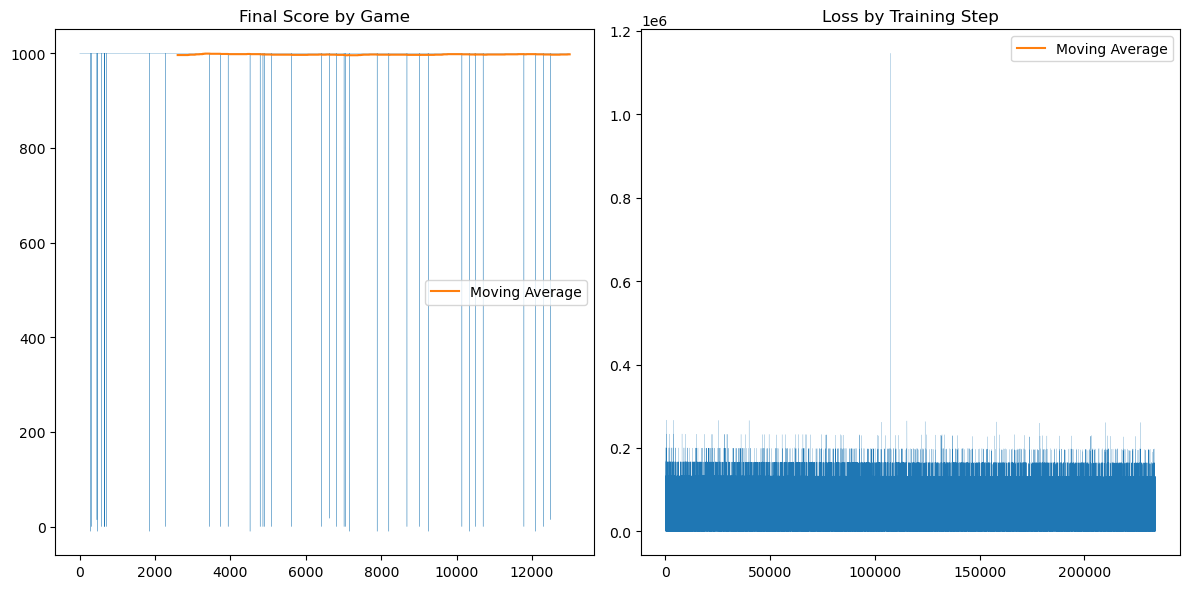

In [10]:
games_to_play, max_game_moves = 13000, 50
loss, score, steps = agent.q_learning(games_to_play=games_to_play, max_game_moves=max_game_moves)

score_df = pd.DataFrame(score, columns=["score"])
score_df['ma'] = score_df["score"].rolling(window=games_to_play // 5).mean()
loss_df = pd.DataFrame(loss, columns=["loss"])
loss_df['ma'] = loss_df["loss"].rolling(window=steps // 5).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(score_df.index, score_df["score"], linewidth=0.2)
ax1.plot(score_df.index, score_df["ma"], label="Moving Average")
ax1.set_title('Final Score by Game')
ax1.legend()
ax2.plot(loss_df.index, loss_df["loss"], linewidth=0.1)
ax2.plot(loss_df.index, loss_df["ma"], label="Moving Average")
ax2.set_title('Loss by Training Step')
ax2.legend()

plt.tight_layout()
plt.show()

In [12]:
final_checkpoint_path = os.path.join("./checkpoints", "q_learning_final_checkpoint.pth")
torch.save(agent.policy_net.state_dict(), final_checkpoint_path)
print(f"Final checkpoint saved: {final_checkpoint_path}")

Final checkpoint saved: ./checkpoints/q_learning_final_checkpoint.pth


In [13]:
def choose_move(agent, board):
    
    if agent == 'random':
        chosen_move = random.choice(list(board.legal_moves))
    
    else:
        bit_state = agent.convert_board_to_bitarray(board)
        valid_moves_tensor, valid_move_dict = agent.mask_valid_moves(board)

        with torch.no_grad():
            tensor = torch.from_numpy(bit_state).float().unsqueeze(0)
            policy_values = agent.policy_net(tensor.to(device), valid_moves_tensor.to(device))
            chosen_move_index = int(policy_values.max(1)[1].view(1, 1))
            
            if chosen_move_index not in valid_move_dict:
                chosen_move = random.choice(list(board.legal_moves))
            else:
                chosen_move = valid_move_dict[chosen_move_index]
                
    return chosen_move


def test(agent, games=1, board_config=None):

    outcomes = []
    for game in range(games):
        
        done = False
        
        # Create a new standard board
        if board_config is None:
            board = chess.Board()
        
        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)
        
        game_moves = 0
        while not done:
            game_moves += 1
            
            # white moves
            if game_moves % 2 != 0:
                board.push(choose_move(agent, board))
            
            # black moves
            else:
                board.push(choose_move("random", board))
                
            done = board.result(claim_draw=True) != '*'

        outcomes.append(board.result(claim_draw=True))

    outcome_dict = {"1-0":"White won", "1/2-1/2":"Draw", "0-1":"Black won"}
    for o in set(outcomes):
        print(f"{o} {outcome_dict[o]}: {round(outcomes.count(o)/len(outcomes)*100)}%")

test(agent, games=20)

1/2-1/2 Draw: 100%


In [14]:
def test(agent, games=1, board_config=None):
    outcomes = []
    
    for game in range(games):
        done = False
        
        # Create a new standard board
        if board_config is None:
            board = chess.Board()
        
        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)
        
        game_moves = 0
        while not done:
            game_moves += 1
            
            # White moves (agent)
            if game_moves % 2 != 0:
                board.push(choose_move(agent, board))
            
            # Black moves (random)
            else:
                board.push(choose_move("random", board))
                
            done = board.result(claim_draw=True) != '*'

        outcomes.append(board.result(claim_draw=True))
    
    # Count results
    agent_wins = outcomes.count("1-0")
    agent_losses = outcomes.count("0-1")
    draws = outcomes.count("1/2-1/2")
    
    # Outcome dictionary for description
    outcome_dict = {"1-0": "White (Agent) won", "1/2-1/2": "Draw", "0-1": "Black (Random) won"}
    
    # Print statistics
    for outcome in set(outcomes):
        print(f"{outcome} ({outcome_dict[outcome]}): {round(outcomes.count(outcome)/len(outcomes)*100)}%")
    
    print("\nSummary:")
    print(f"Agent wins: {agent_wins}")
    print(f"Agent losses: {agent_losses}")
    print(f"Draws: {draws}")

test(agent, 20)

1/2-1/2 (Draw): 95%
0-1 (Black (Random) won): 5%

Summary:
Agent wins: 0
Agent losses: 1
Draws: 19


In [15]:
def configure_stockfish_using_skill_level(skill_level):
    stockfish = Stockfish(path=stockfish_path)
    stockfish.set_skill_level(skill_level)
    return stockfish

def configure_stockfish_using_rating(elo_rating):
    stockfish = Stockfish(path=stockfish_path)
    stockfish.set_elo_rating(elo_rating)
    return stockfish

def play_single_stockfish_game(agent, stockfish, max_moves=50):
    board = chess.Board()
    stockfish.set_fen_position(board.fen())

    for move_count in range(max_moves):
        if board.turn:
            _, move, _, _ = agent.select_action(board, evaluate=True)
        else:
            move = chess.Move.from_uci(stockfish.get_best_move())
        board.push(move)
        stockfish.set_fen_position(board.fen())

        if board.is_game_over():
            break

    return board.result()

def evaluate_agent(agent, skill_levels, games_per_rating=20):
    results = []

    for level in skill_levels:
        stockfish = configure_stockfish_using_skill_level(level)
        outcomes = {"Wins": 0, "Losses": 0, "Draws": 0}

        for _ in range(games_per_rating):
            result = play_single_stockfish_game(agent, stockfish)
            if result == "1-0":
                outcomes["Wins"] += 1
            elif result == "0-1":
                outcomes["Losses"] += 1
            else:
                outcomes["Draws"] += 1

        win_rate = (outcomes["Wins"] + 0.5 * outcomes["Draws"]) / games_per_rating
        outcomes["Win Rate"] = win_rate
        outcomes["Stockfish Level"] = level
        results.append(outcomes)

        print(f"Stockfish level: {level}: {outcomes}")

    return results

stockfish_skill_levels = [1, 5, 10, 15] 
results = evaluate_agent(agent, stockfish_skill_levels)

Stockfish level: 1: {'Wins': 0, 'Losses': 8, 'Draws': 12, 'Win Rate': 0.3, 'Stockfish Level': 1}
Stockfish level: 5: {'Wins': 0, 'Losses': 13, 'Draws': 7, 'Win Rate': 0.175, 'Stockfish Level': 5}
Stockfish level: 10: {'Wins': 0, 'Losses': 19, 'Draws': 1, 'Win Rate': 0.025, 'Stockfish Level': 10}
Stockfish level: 15: {'Wins': 0, 'Losses': 18, 'Draws': 2, 'Win Rate': 0.05, 'Stockfish Level': 15}


##### 